RECORDAR DESZIPEAR PROPERATTI.ZIP

In [66]:
import pandas as pd
import numpy as np

In [67]:
data = pd.read_csv("properatti.csv", index_col=0)
data.shape

(121220, 25)

In [68]:
data.dtypes

operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: object

# Verificar si existen filas con todos los datos faltantes - PASAR A ANALISIS INICIAL - REVISAR CODIGO

In [69]:
df_usd_m2 = data['price_usd_per_m2']
mask_nan_uds_m2= df_usd_m2.isna()

In [70]:
mask_nan_sup_total=data["surface_total_in_m2"].isna()
mask_nan_sup_cubierta=data["surface_covered_in_m2"].isna()
mask_nan_rooms=data["rooms"].isna()


In [71]:
mask_nan_columnas = (mask_nan_sup_total == True) & (mask_nan_sup_cubierta == True) &(mask_nan_rooms == True) &(mask_nan_uds_m2 == True) 
mask_nan_columnas.value_counts()

False    113090
True       8130
dtype: int64

#Nota: volver a revisar estos datos despues de haber completado todas las columnas con los datos extraidos del campo descripcion - inicial 8130

## Columna Superficie

## REVISAR CONSISTENCIA DE DATOS PARA LAS COLUMNAS SUP TOTAL Y CUBIERTA!

In [72]:
mask_consistencia_sup = data["surface_total_in_m2"] < data["surface_covered_in_m2"]

In [73]:
data_consistencia_metros=data[mask_consistencia_sup]
print(data_consistencia_metros[['surface_covered_in_m2','surface_total_in_m2']].sample(10))
print(data_consistencia_metros.property_type.value_counts())
print(data.property_type.value_counts())

        surface_covered_in_m2  surface_total_in_m2
35478                   170.0                100.0
1598                    105.0                 90.0
52544                    75.0                 64.0
107431                  277.0                 42.0
38448                   128.0                 90.0
22453                   160.0                100.0
45499                   220.0                208.0
6870                     75.0                 60.0
44773                    70.0                 36.0
10706                   200.0                155.0
house        666
apartment    351
store         47
PH            42
Name: property_type, dtype: int64
apartment    71065
house        40268
PH            5751
store         4136
Name: property_type, dtype: int64


In [74]:
data_consistencia_metros.shape[0]/data.shape[0]

0.009123906946048506

El porcentaje de registros con estos errores es menor al 1%, no hemos podido encontrar un patrón sencillo en estos errores

#### 1- detectar de outliers

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns

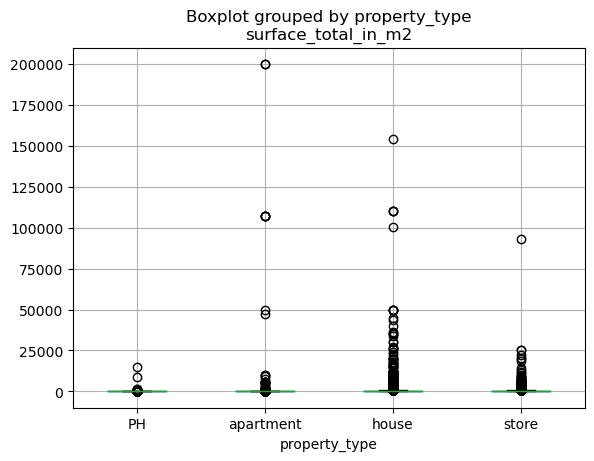

In [76]:
data.boxplot(column= "surface_total_in_m2", by="property_type") 
plt.show()

se detectan outliers para superficies mayores a 75000 m2. ### ver consistencia en outliers

##### VER SI ELIMINAMOS OUTLIERS!!!!

#### 2-Recuperar informacion faltante a través de regex de la columna descripción

In [77]:
import re

In [78]:
serie_descripcion = data["description"]

In [79]:
pattern_sup_m2 = "(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"
pattern_sup_m2_regex = re.compile(pattern_sup_m2,  re.IGNORECASE)

In [80]:
import numpy as np
sup_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex.search(x))


In [81]:
sup_match.sample(10)

38906                                                  None
90926                                                  None
76010                                                  None
70072                                                  None
61498                                                  None
118477                                                 None
97483                                                  None
36369     <re.Match object; span=(272, 278), match='52 m...
75681                                                  None
26308     <re.Match object; span=(472, 480), match='113,...
Name: description, dtype: object

In [82]:
mask_sup_match_notnull= sup_match.notnull()

data.loc[mask_sup_match_notnull, "Sup_m2_Clean"] = sup_match[mask_sup_match_notnull].apply(lambda x: x.group("sup"))


In [83]:
#data.loc[mask_sup_match_notnull, ["surface_total_in_m2", "surface_covered_in_m2", "Sup_m2_Clean"]]----para borrar

In [84]:
serie_sup_m2_clean=data["Sup_m2_Clean"]

In [85]:
print(serie_sup_m2_clean.notnull().sum())
serie_sup_m2_clean.isnull().sum()

40087


81133

In [86]:
#SE ARREGLAN ERRORES DE COLUMNA DE REGEX PARA PODER SER UTILIZADOS EN ESTADISTICA

pattern_sup_m2_dos="(?P<supdos>\d{2,})"
pattern_sup_m2_regex_dos=re.compile(pattern_sup_m2_dos)
sup_match_dos = serie_sup_m2_clean.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex_dos.search(x))
mask_sup_match_notnull_dos= sup_match_dos.notnull()
data.loc[mask_sup_match_notnull_dos, "Sup_m2_Clean_dos"] = sup_match_dos[mask_sup_match_notnull_dos].apply(lambda x: x.group("supdos"))
# data["Sup_m2_Clean_dos"].median()


##### Se supone que para PH, apartments y store la superficie cubierta es la misma que la superficie total, *se descarta house entendiendo que estas pueden contar con "patio". con estos datos se reemplazan los valores faltantes(no lo pude separar -VER!!!!*. PASAR PARA ARRIBA para dar orden al analisis

In [87]:
data_limpia= data.copy()


In [88]:
data_limpia["sup_m2_total_limpia"] = data_limpia["surface_total_in_m2"]

In [89]:
data_key_not_null_mask = np.logical_and(data.property_type.notnull(), data.surface_covered_in_m2.notnull())
data_key_not_null = data.loc[data_key_not_null_mask, :]
data_key_not_null.shape

(101313, 27)

In [90]:
data_key_not_null_grouped_tipo_sup= data_key_not_null.groupby(["property_type", "surface_covered_in_m2"])


In [91]:
data_fillna= data_key_not_null_grouped_tipo_sup["surface_total_in_m2"].transform(lambda grp: grp.fillna(grp.mean()))
data_fillna

0          55.0
2          55.0
4          35.0
6         106.0
7          45.0
          ...  
121215    113.0
121216    360.0
121217     46.0
121218     48.0
121219     77.0
Name: surface_total_in_m2, Length: 101313, dtype: float64

In [92]:
data_limpia["sup_m2_total_limpia"].fillna(data_fillna,inplace=True)
#data_limpia.loc[mask_sup_match_notnull, ["surface_total_in_m2", "sup_m2_total_limpia", "property_type"]]

In [93]:
data_limpia["sup_m2_total_limpia"].isnull().sum()

12642

### se adicionan los datos obtenidos de la columna descripcion.

In [94]:
data_limpia["sup_m2_total_limpia"].fillna(data_limpia["Sup_m2_Clean_dos"],inplace=True)

In [95]:
data_limpia["sup_m2_total_limpia"].isnull().sum()/data["surface_total_in_m2"].isnull().sum()*100

23.39300244100895

### se recupera el 23% de la informacion faltante al suponer superficie cubierta como superficie total y al extraer informacion con metodo regex de la columna descripción 


In [96]:
data_limpia["sup_m2_total_limpia"].isnull().sum()/data_limpia.shape[0]*100

7.589506682065665

#### se redujo de 32% a 7.6% la información faltante.

# Para los datos faltantes en la columna de interés, se desea agrupar por tipo de propiedad para sacar la mediana de los m2 totales y estratificar los valores. de esta manera podriamos tener los datos completos. REVISAR SI ES NECESARIO

# Columna Rooms

### Revisar relacion precio vs rooms. comparar propiedades similares con distinta cantidad de rooms para ver si varia sustancialmente el precio - PENDIENTE

In [97]:
## Arranco por los monoambientes
#pattern_mono='(?P<sup>\d{2,}(,|.\d+)?)\s*(mono)\S+?'
pattern_mono='(mono)|(mono\s+\w+)|(mono\.+\w+)|(mono\-+\w+)|(mono\w+)'
pattern_mono_regex=re.compile(pattern_mono,re.IGNORECASE)

In [98]:
serie_mono_descripcion=data['description']
mono_match = serie_mono_descripcion.apply(lambda x: x if x is np.NaN else pattern_mono_regex.search(x))
#sup_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_sup_m2_regex.search(x))


In [99]:
mask_mono_match=mono_match.notnull()
col_mono_prueba_nulos=mono_match[mask_mono_match]
col_mono_prueba_nulos.shape

(10749,)

In [100]:
data.loc[mask_mono_match,'Ambientes_Clean']= 1

#### Ahora me enfoco en todos los departamentos que no sean monos, uso por ahora ambientes, para evitar confusiones con dormitorios y habitaciones

In [101]:
#pattern_rooms= "(?P<dorm>\d+.?Dorm|\d+.?dorm|\d+.?DORM|\d+.?AMB|\d+.?Amb|\d+.?amb|\d+.?hab|\d+.?HAB|\d+.?Hab|monoamb)"
#pattern_rooms= "(?P<dorm>\d{2,}(,|.\d+)?)\s*(Dorm|amb|monoamb).?Dorm|\d+.?dorm|\d+.?DORM|\d+.?AMB|\d+.?Amb|\d+.?amb|\d+.?hab|\d+.?HAB|\d+.?Hab|monoamb)"
#"(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"(mono)|(mono\s+\w+)|(mono\.+\w+)|(mono\-+\w+)|(mono\w+)
#"(?P<sup>\d{2,}(,|.\d+)?)\s*(m2|metros|mts)"
pattern_ambs="(?P<num>\s\d{1,2})\s*(\samb\w*\s)"
pattern_ambs_regex=re.compile(pattern_ambs,re.IGNORECASE)

In [102]:
mask_mono_nulo=mono_match.isnull()
col_mono_nulo=mono_match[mask_mono_nulo]
pattern_ambs_match=serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_ambs_regex.search(x))

In [103]:
pattern_ambs_match.value_counts()

<re.Match object; span=(2, 15), match=' 3 ambientes '>        1
<re.Match object; span=(2, 9), match=' 3 amb '>               1
<re.Match object; span=(17, 30), match=' 2 ambientes '>       1
<re.Match object; span=(84, 97), match=' 3 ambientes '>       1
<re.Match object; span=(155, 169), match=' 2  ambientes '>    1
                                                             ..
<re.Match object; span=(117, 130), match=' 3 ambientes '>     1
<re.Match object; span=(118, 131), match=' 4 ambientes '>     1
<re.Match object; span=(129, 142), match=' 4 ambientes '>     1
<re.Match object; span=(223, 236), match=' 2 ambientes '>     1
<re.Match object; span=(577, 590), match=' 3 ambientes '>     1
Name: description, Length: 27506, dtype: int64

In [104]:
type(pattern_ambs_match)

pandas.core.series.Series

In [105]:
print(pattern_ambs_match.isna().sum())
print(pattern_ambs_match.notna().sum())

93714
27506


In [106]:
#Cambio los None por NaN
pattern_ambs_match_2=pattern_ambs_match.fillna(np.NaN)

In [107]:
pattern_ambs_match_3=pattern_ambs_match_2.apply(lambda x: x if x is np.NaN else x[0])

In [108]:
nuevo_pattern='(?P<num>\d{1,2})'
nuevo_pattern_regex=re.compile(nuevo_pattern)
nuevo_pattern_match=pattern_ambs_match_3.apply(lambda x: x if x is np.NaN else nuevo_pattern_regex.search(x))
nuevo_pattern_match.notnull().sum()

27506

In [109]:
mask_def_not_null= nuevo_pattern_match.notnull()
mask_mono_nulo=mono_match.isnull()
data.loc[mask_mono_nulo, "Ambientes_Clean"] = nuevo_pattern_match[mask_mono_nulo].apply(lambda x: x if x is np.NaN else x.group('num'))


In [110]:
serie_rooms_clean=data["Ambientes_Clean"]
serie_rooms_clean.notnull().sum()
serie_rooms_clean.value_counts()
data[['Ambientes_Clean','rooms']].sample(10)

,Ambientes_Clean,rooms
17020,NaN,5.0
65484,NaN,NaN
85971,NaN,NaN
119447,1.0,1.0
7147,NaN,NaN
64823,6,NaN
23784,NaN,5.0
66348,NaN,NaN
77892,NaN,NaN
75409,1.0,NaN


In [111]:
mask_room_no_nula = data.rooms.notnull()
data.Ambientes_Clean[mask_room_no_nula]=data.rooms[mask_room_no_nula]
data[['Ambientes_Clean','rooms']][mask_room_no_nula]

C:\Users\ornel\AppData\Local\Temp\ipykernel_11228\457002546.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.Ambientes_Clean[mask_room_no_nula]=data.rooms[mask_room_no_nula]


,Ambientes_Clean,rooms
13,1.0,1.0
14,1.0,1.0
16,4.0,4.0
17,3.0,3.0
19,3.0,3.0
...,...,...
120203,2.0,2.0
120204,1.0,1.0
120205,5.0,5.0
120206,4.0,4.0


In [112]:
#Pctje no nulo de rooms
print(data.Ambientes_Clean.notnull().sum()/data.shape[0])
print(data.rooms.notnull().sum()/data.shape[0])

0.5491585546939449
0.3909420887642303


Recuperamos el 16% de rooms

Procedo a imputar los ambientes

In [113]:
mask_amb_not_null=data.Ambientes_Clean.notnull()
data.loc[mask_amb_not_null,'Ambientes_Clean']=data.loc[mask_amb_not_null,'Ambientes_Clean'].astype('int')

In [114]:
data.Ambientes_Clean=data.Ambientes_Clean.astype('Int64')

In [115]:
ambientes_non_null=data.Ambientes_Clean[mask_amb_not_null]
metros_mask_amb_non_null=data.surface_covered_in_m2[mask_amb_not_null]

In [116]:
data.surface_covered_in_m2=data.surface_covered_in_m2.astype('Int64')
data[['Ambientes_Clean','surface_covered_in_m2']].dtypes

Ambientes_Clean          Int64
surface_covered_in_m2    Int64
dtype: object

In [117]:
data['size_rooms']=np.where(data['Ambientes_Clean'].notnull(),data['surface_covered_in_m2']/data['Ambientes_Clean'],np.NaN)

In [118]:
data[['Ambientes_Clean','surface_covered_in_m2','size_rooms']]

,Ambientes_Clean,surface_covered_in_m2,size_rooms
0,<NA>,40,NaN
1,<NA>,<NA>,NaN
2,<NA>,55,NaN
3,3,<NA>,NaN
4,<NA>,35,NaN
...,...,...,...
121215,<NA>,93,NaN
121216,<NA>,360,NaN
121217,1,39,39.0
121218,<NA>,48,NaN


# Ahora completo los faltantes de tamaño promedio con groupby

In [119]:
fill_values=data.groupby('property_type').size_rooms.median()

In [120]:
fill_values_df=pd.DataFrame(fill_values)
fill_values_df.reset_index(inplace=True)
fill_values_df.head(5)

,property_type,size_rooms
0,PH,23.50
1,apartment,26.00
2,house,40.00
3,store,57.75


In [121]:
#Lo mergeamos con el df
data = data.merge(fill_values_df,on='property_type',suffixes=('','_median'),how='left')
data.sample(10)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,expenses,properati_url,description,title,image_thumbnail,Sup_m2_Clean,Sup_m2_Clean_dos,Ambientes_Clean,size_rooms,size_rooms_median
41430,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.9379978,-60.6477057",-32.937998,-60.647706,...,NaN,http://www.properati.com.ar/18u5s_venta_depart...,UBICADO EN LA ZONA MAS IMPORTANTE DE LA CIUDAD...,DOS DORMITORIOS - OPORTUNIDAD,https://thumbs4.properati.com/0/8t9__OJi90NAeL...,200,200,<NA>,NaN,26.0
55496,sell,apartment,Ramos Mejía,|Argentina|Bs.As. G.B.A. Zona Oeste|La Matanza...,Argentina,Bs.As. G.B.A. Zona Oeste,3429617.0,NaN,NaN,NaN,...,NaN,http://www.properati.com.ar/19p6u_venta_depart...,- Publicado a traves de VisualGestion -,Departamento en Venta Ramos Mejia / La Matanza...,NaN,NaN,NaN,2,13.0,26.0
101791,sell,apartment,San Isidro,|Argentina|Bs.As. G.B.A. Zona Norte|San Isidro...,Argentina,Bs.As. G.B.A. Zona Norte,3428983.0,NaN,NaN,NaN,...,800.0,http://www.properati.com.ar/1bpt4_venta_depart...,Edificio desarrollado en dos cuerpos de 3 piso...,3 de febrero 300 Depto. 2 amb 60mts cub a estr...,https://thumbs4.properati.com/7/T_Dn9mqn5TwIHS...,NaN,NaN,<NA>,NaN,26.0
4658,sell,house,Santa Fe,|Argentina|Santa Fe|Santa Fe|,Argentina,Santa Fe,3836277.0,"-31.6400462,-60.6872747",-31.640046,-60.687275,...,NaN,http://www.properati.com.ar/15ncd_venta_casa_s...,Hermosa propiedad de 2 plantas. Consta de 4 do...,HERMOSA PROPIEDAD DE 2 PLANTAS,https://thumbs4.properati.com/2/c3Qr98Q4kst7rh...,NaN,NaN,<NA>,NaN,40.0
120819,sell,house,Belgrano,|Argentina|Capital Federal|Belgrano|,Argentina,Capital Federal,3436077.0,"-34.5767328045,-58.474588324",-34.576733,-58.474588,...,NaN,http://www.properati.com.ar/1ciek_venta_casa_b...,EXCELENTE CASA - CONSTRUÍDA CO...,Casa - Belgrano,https://thumbs4.properati.com/7/LKdPlUVjVqgB7X...,"12,60",12,<NA>,NaN,40.0
58922,sell,apartment,Rosario,|Argentina|Santa Fe|Rosario|,Argentina,Santa Fe,3838574.0,"-32.9468724,-60.6758863",-32.946872,-60.675886,...,NaN,http://www.properati.com.ar/19wid_venta_depart...,1119-AE00583 Rosario: Rivera Indarte 3732 P1 D...,"Rosario: Rivera Indarte 3732 P1 D3, departamen...",https://thumbs4.properati.com/8/NS6F8cyb_xnWkL...,40,40,1,40.0,26.0
96914,sell,house,Concordia,|Argentina|Entre Ríos|Concordia|,Argentina,Entre Ríos,3435260.0,NaN,NaN,NaN,...,NaN,http://www.properati.com.ar/1bjc0_venta_casa_c...,Casa de dos dormitorios en Barrio 6 de Febrero...,Casa - Concordia,https://thumbs4.properati.com/4/jALTyu5uMjjzTI...,NaN,NaN,<NA>,NaN,40.0
63810,sell,apartment,Valeria del Mar,|Argentina|Buenos Aires Costa Atlántica|Valeri...,Argentina,Buenos Aires Costa Atlántica,3427561.0,"-37.1440088395,-56.8810629873",-37.144009,-56.881063,...,NaN,http://www.properati.com.ar/1a9hw_venta_depart...,El Complejo de Apartamentos Arenas II se encue...,Ed. ARENAS II Valeria del Mar,https://thumbs4.properati.com/0/brpsjbvnrDdcfX...,150,150,2,19.0,26.0
93031,sell,apartment,Córdoba,|Argentina|Córdoba|Córdoba|,Argentina,Córdoba,3860259.0,NaN,NaN,NaN,...,NaN,http://www.properati.com.ar/1bdnd_venta_depart...,Entregas de $840.000 más cuotas. Descripción: ...,Excelente Oportunidad en Cardinales Nuevo Suquia,https://thumbs4.properati.com/6/KEJzKuZsTBNujU...,NaN,NaN,<NA>,NaN,26.0
22089,sell,apartment,Ituzaingó,|Argentina|Bs.As. G.B.A. Zona Oeste|Ituzaingó|,Argentina,Bs.As. G.B.A. Zona Oeste,3433359.0,"-34.6465816,-58.688894",-34.646582,-58.688894,...,NaN,http://www.properati.com.ar/17huf_venta_depart...,TRES DEPARTAMENTOS A TERMINAR CONSULTE VALOR,Departamento en Venta. 156 m2c,https://thumbs4.properati.com/9/dhgp0g3jh9JZPT...,NaN,NaN,<NA>,NaN,26.0


In [122]:
data.size_rooms.fillna(data.size_rooms_median,inplace=True)

In [123]:
mask_ambientes_null=data.Ambientes_Clean.isnull()

In [124]:
data['ambientes_2']=data.surface_covered_in_m2/data.size_rooms
#data['ambientes_2']=data['ambientes_2'].astype('Int64')
data['ambientes_2'].dtype
data['Ambientes_Clean']=data['Ambientes_Clean'].astype('float64')
data['Ambientes_Clean'].dtype
data.Ambientes_Clean.fillna(data.ambientes_2,inplace=True)


In [125]:
print(data.Ambientes_Clean.notnull().sum()/data.shape[0])
print(data.rooms.notnull().sum()/data.shape[0])

0.9079607325523841
0.3909420887642303


# Se logró imputar el 90% de Rooms!!! Si reemplazamos los m2_covered por los m2 imputados podemos lograr el 90%

poner arriba

##### Intentamos ver si los datos faltantes de rooms disminuyen si descontamos las tiendas

In [126]:
mask_residencial= data.property_type != 'store'
tipos_residenciales=data.property_type[mask_residencial]
rooms_residenciales=data.rooms[mask_residencial]
df_residencial=pd.DataFrame(tipos_residenciales)
df_residencial['rooms']=rooms_residenciales

In [127]:
data.rooms.value_counts()

3.0     12567
2.0     12433
4.0      7937
1.0      7377
5.0      3782
6.0      1403
7.0       770
8.0       409
10.0      226
9.0       184
11.0       72
12.0       65
13.0       33
14.0       27
15.0       26
17.0       16
16.0       11
20.0       11
22.0        8
18.0        6
21.0        5
19.0        4
30.0        4
25.0        4
32.0        3
23.0        2
24.0        1
31.0        1
29.0        1
27.0        1
28.0        1
Name: rooms, dtype: int64

In [128]:
shape_df=df_residencial.shape
count_res=shape_df[0]


In [129]:
nulos_room=df_residencial.rooms.isna().sum(axis=0)
pctje_nulos_rooms=nulos_room/count_res
pctje_nulos_rooms

0.5961446482867001

Veamos cuantas rooms tienen las tiendas

In [130]:
mask_comercial= data.property_type == 'store'
tipos_comerciales=data.property_type[mask_comercial]
rooms_comerciales=data.rooms[mask_comercial]
df_comercial=pd.DataFrame(tipos_comerciales)
df_comercial['rooms']=rooms_comerciales
df_comercial.rooms.value_counts()

1.0     55
2.0     17
3.0     13
7.0      6
4.0      4
5.0      4
10.0     3
6.0      2
8.0      1
Name: rooms, dtype: int64

#### Recordemos que el porcentaje original de nulos era similar, 

Veamos si los faltantes de expensas disminuyen sacando tiendas y casas

In [131]:
mascara_sin_casas=df_residencial.property_type !='house'
expensas_residenciales=data.expenses[mask_residencial]
df_residencial['expenses']=expensas_residenciales
expensas_deps_ph=expensas_residenciales[mascara_sin_casas]
null_exp_clean=expensas_deps_ph.isnull().sum()
shape_exp_clean=expensas_deps_ph.shape
pctje_null_exp_clean=null_exp_clean/shape_exp_clean[0]
pctje_null_exp_clean
type_deps_ph=df_residencial.property_type[mascara_sin_casas]
type_deps_ph.value_counts()

apartment    71065
PH            5751
Name: property_type, dtype: int64

In [132]:
expensas_deps_ph.isnull().sum()/expensas_deps_ph.shape[0]

0.8496146636117475

Probemos ahora sacando los nulos de rooms para tratar de aplicar un promedio del tamaño de las rooms

In [133]:
mask_rooms_no_nulas=data.rooms.notnull()
rooms_no_nulas=data.rooms.loc[mask_rooms_no_nulas]
sf_room_no_nulas=data.surface_covered_in_m2.loc[mask_rooms_no_nulas]
df_rooms_clean=pd.DataFrame(rooms_no_nulas)
df_rooms_clean['m2_covered']=sf_room_no_nulas
mask_rooms_no_nulas.value_counts()

False    73830
True     47390
Name: rooms, dtype: int64

El pctje de m2 cubiertos es ligeramente menor, por lo que no hay mucha correlacion entre nulidad de rooms y nulidad de m2_covered
Hay que inputar los m2 cubiertos faltantes antes de poder avanzar a tener un promedio de cuantos m2 tiene cada habitación
Para imputar las rooms, me imagino hay que inputar promedio por tipo de propiedad, hace falta por barrio, o alguna caracteristica extra?? Para mi no hace falta

# Recuperar datos de precio total en dolares

### REVISAR CONSISTENCIA ENTRE DATOS ARS Y USD

### Nos centramos en este campo, por dos motivos. Sabiendo que la finalidad de esta limpieza es lograr obtener una base de datos con valores que me permitan luego armar un modelo que me ayude a determinar el valor de una propiedad, entendemos que el campo precio es el mas importante. Uno de los motivos por el cual nos centramos en el precio en dolares, es porque este campo no se ve influenciado por la inflación, por otro lado contamos con bastantes datos en la columna lo cual disminuye el error por supuestos o calculos mal hechos.

### 1-Extraer información con regex de columna descripción

In [134]:
import re
serie_descripcion = data["description"]

pattern_usd = "(?P<usd>(usd|u[$]d)\s*?(\d{2,}(,|.\d+)?))"
pattern_usd_regex = re.compile(pattern_usd,  re.IGNORECASE)

import numpy as np
usd_match = serie_descripcion.apply(lambda x: x if x is np.NaN else pattern_usd_regex.search(x))

mask_usd_match_notnull= usd_match.notnull()

data.loc[mask_usd_match_notnull, "usd_clean"] = usd_match[mask_usd_match_notnull].apply(lambda x: x.group(0))


In [135]:
serie_usd_clean=data["usd_clean"]

In [141]:
pattern_usd_dos="(?P<usddos>(\d{2,}(,|.\d+)?))"
pattern_usd_regex_dos=re.compile(pattern_usd_dos)
usd_match_dos = serie_usd_clean.apply(lambda x: x if x is np.NaN else pattern_usd_regex_dos.search(x))
mask_usd_match_notnull_dos= usd_match_dos.notnull()
data_limpia.loc[mask_usd_match_notnull_dos, "usd_clean_dos"] = usd_match_dos[mask_usd_match_notnull_dos].apply(lambda x: x.group("usddos"))


In [137]:
data_limpia["precio_usd_limpio"]=data_limpia["price_aprox_usd"]

In [142]:
data_limpia["precio_usd_limpio"].fillna(data_limpia["usd_clean_dos"],inplace=True)

In [143]:
data_limpia["precio_usd_limpio"].isnull().sum()

20166

In [144]:
(1-data_limpia["precio_usd_limpio"].isnull().sum()/data["price_aprox_usd"].isnull().sum())*100

1.1954924056834848

Se recuperó el 1.2% de la informacion de precios en dolares del campo descripcion. La recuperacion de datos no es significativa.

### 2-comprobar si las columnas precio ARS y USD pueden matchear- listo

In [145]:
mask_ARS_empty=data["price_aprox_local_currency"].isnull()
mask_ARS_empty.value_counts()

False    100810
True      20410
Name: price_aprox_local_currency, dtype: int64

In [146]:
mask_USD_empty=data["price_aprox_usd"].isnull()
mask_USD_empty.value_counts()

False    100810
True      20410
Name: price_aprox_usd, dtype: int64

In [147]:
mask_precio_empty=mask_ARS_empty&mask_USD_empty
data[mask_precio_empty].shape

(20410, 33)

##### coinciden la cantidad de filas vacias en cada campo, por lo cual no es posible completar completar datos vacios de USD con ARS sacados de la columna "price_aprox_local_currency"

### 3-Determinar la variacion precio con rooms y superficie---- ver de pasar arriba

calculamos la correlacion entre variables

In [148]:
import matplotlib.pyplot as plt
import seaborn as sns


In [149]:
df_surf_float = data["surface_total_in_m2"].astype(float) 
df_room_float = data['rooms'].astype(float) 
df_price_float = data['price_aprox_usd'].astype(float) 
df_tipo = data['property_type']

In [150]:
data_tipo_usd_sup_room=pd.DataFrame((df_tipo,df_surf_float,df_room_float,df_price_float))
data_tipo_usd_sup_room_T=data_tipo_usd_sup_room.T
data_tipo_usd_sup_room_T.sample(10)

,property_type,surface_total_in_m2,rooms,price_aprox_usd
37717,apartment,36.0,1.0,105000.0
79731,PH,NaN,NaN,170000.0
118283,apartment,53.0,NaN,NaN
12352,apartment,243.0,4.0,750000.0
6470,house,NaN,NaN,NaN
50000,house,41.0,NaN,NaN
69438,apartment,75.0,NaN,208950.0
57279,apartment,NaN,2.0,NaN
93304,house,190.0,NaN,105998.14
34431,apartment,31.0,2.0,65000.0


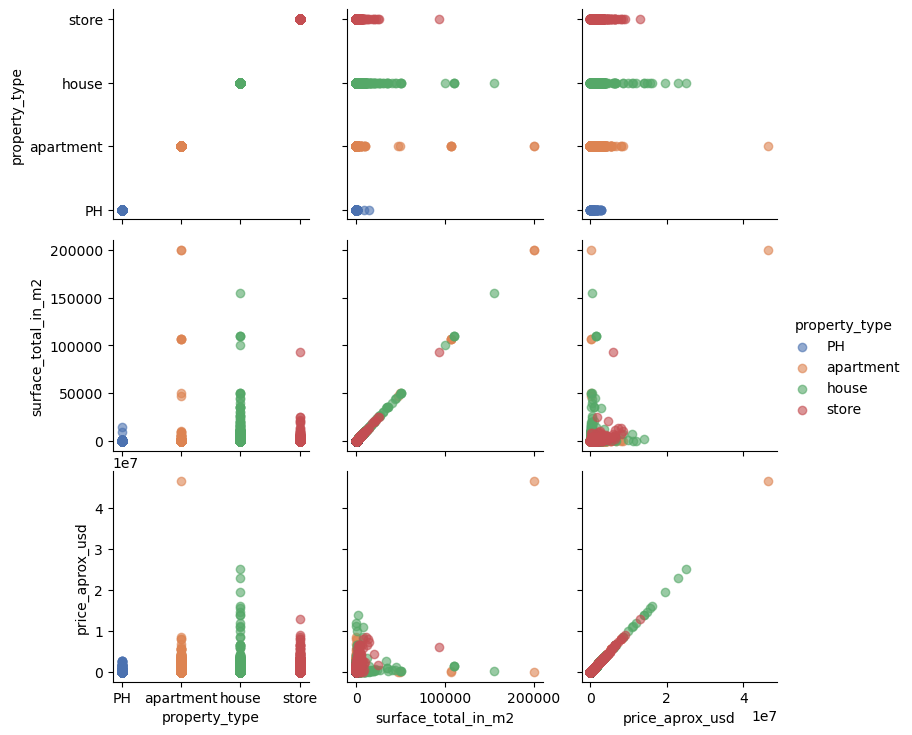

In [191]:
g = sns.PairGrid(data_tipo_usd_sup_room_T, vars=['property_type','surface_total_in_m2','price_aprox_usd'],hue='property_type', palette='deep')
g.map(plt.scatter, alpha=0.6)
g.add_legend()

#### Se puede ver una relacion entre precio tipo de departamento y superficie, no asi con la cantidad de habitaciones-REVISAR

*nota: cambiar a data_limpia cuando arreglemos el problema de regex de esa columna para obtener datos no influenciados por los datos faltantes

### 4-Calcular el precio total = Precio u$d/m2 * Superficie en base al punto anterior para las filas con datos faltantes

#NOTA: EVALUAR ELIMINAR LOS VALORES Q NO SON PESOS ARGENTINOS PARA PODER HACER UNA CONVERSION DE TODOS LOS VALORES A USD - PENDIENTE

#Se toma el valor medio del precio de propiedad por tipo de propiedad y se completan faltantes.

In [152]:
data_key_not_null_mask_precio = np.logical_and(data.property_type.notnull(), data.price_aprox_usd.notnull())
data_key_not_null_precio = data.loc[data_key_not_null_mask, :]

data_key_not_null_grouped_tipo_precio= data_key_not_null_precio.groupby(["property_type", 'price_aprox_usd'])


data_fillna_precio= data_key_not_null_grouped_tipo_precio['price_aprox_usd'].transform(lambda grp: grp.fillna(grp.mean()))
data_fillna_precio

data_limpia["precio_usd_limpio"].fillna(data_fillna,inplace=True)

In [153]:
(1-data_limpia["precio_usd_limpio"].isnull().sum()/data["price_aprox_usd"].isnull().sum())*100

67.05536501714846

Se recupera el 67% de la informacion faltante 

In [154]:
data_limpia["precio_usd_limpio"].isnull().sum()/data_limpia.shape[0]*100

5.546939448935819

queda el 5.5% de la columna con faltantes.

Cálculo cambio entre ARS y USD 

In [155]:
import numpy as np
change = data['price_aprox_local_currency'] / data['price_aprox_usd']
change.median()

17.6445

In [156]:
print(data.surface_covered_in_m2.notnull().sum()/data.shape[0])
print(data.sup_m2_total_limpia.notnull().sum()/data.shape[0])

0.8357779244349117
0.6755650882692625


## Procedemos a imputar los m2 faltantes de total como = covered para 

In [170]:
data_limpia['sup_m2_total_limpia']= pd.to_numeric(data_limpia['sup_m2_total_limpia'])
data_limpia['coef_ajuste_m2']=np.where(data_limpia['surface_covered_in_m2'].notnull(),data_limpia['sup_m2_total_limpia']/data_limpia['surface_covered_in_m2'],np.NaN)

In [177]:
data_limpia.coef_ajuste_m2.sample(5)

102838     1.137931
116440          NaN
96279      1.189189
41329     46.875000
37186      2.307692
Name: coef_ajuste_m2, dtype: float64

In [183]:
#Ahora los agrupo por groupby
fill_values_m2=data_limpia.groupby('property_type').coef_ajuste_m2.median()

In [179]:
fill_values_m2_df=pd.DataFrame(fill_values_m2)
fill_values_m2_df.reset_index(inplace=True)
fill_values_m2_df.head(5)

,property_type,coef_ajuste_m2
0,PH,1.269658
1,apartment,1.126896
2,house,1.800000
3,store,1.000000


In [185]:
data_limpia = data_limpia.merge(fill_values_m2_df,on='property_type',suffixes=('','_median'),how='left')
data_limpia.sample(5)

,operation,property_type,place_name,place_with_parent_names,country_name,state_name,geonames_id,lat-lon,lat,lon,...,description,title,image_thumbnail,Sup_m2_Clean,Sup_m2_Clean_dos,sup_m2_total_limpia,precio_usd_limpio,usd_clean_dos,coef_ajuste_m2,coef_ajuste_m2_median
77643,sell,apartment,Villa Luro,|Argentina|Capital Federal|Villa Luro|,Argentina,Capital Federal,3427407.0,"-34.6395938,-58.5006643",-34.639594,-58.500664,...,"Venta departamento 3 ambientes en Villa Luro, ...",Departamento - Villa Luro,https://thumbs4.properati.com/5/6f86SNdhWs4aKB...,NaN,NaN,78.0,173000.0,NaN,1.114286,1.126896
12284,sell,house,Morón,|Argentina|Bs.As. G.B.A. Zona Oeste|Morón|Morón|,Argentina,Bs.As. G.B.A. Zona Oeste,3430544.0,"-34.6541213,-58.6101213",-34.654121,-58.610121,...,Venta de Casa 4 AMBIENTES *Apta Crédito* en Mo...,CASA EN VENTA,https://thumbs4.properati.com/3/oLCXn_mYgkIEX6...,120,120,156.0,220000.0,NaN,1.300000,1.800000
115669,sell,apartment,Córdoba,|Argentina|Córdoba|Córdoba|,Argentina,Córdoba,3860259.0,"-31.417198,-64.180184",-31.417198,-64.180184,...,Gestión Inmobiliaria ofrece: DEPARTAMENTO DE C...,DEPARTAMENTO DE CATEGORÍA SOBRE CHACABUCO AL 100,https://thumbs4.properati.com/5/C3RRf1w7M5_1--...,NaN,NaN,NaN,160000.0,NaN,NaN,1.126896
48392,sell,apartment,Boedo,|Argentina|Capital Federal|Boedo|,Argentina,Capital Federal,3436003.0,"-34.623977,-58.4245654",-34.623977,-58.424565,...,DEPARTAMENTO 3 AMBIENTES PISO 7° AL FRENTE CON...,DEPARTAMENTO VENTA BOEDO,https://thumbs4.properati.com/4/EJ0wJ3q6BLgcid...,NaN,NaN,60.0,125000.0,NaN,1.034483,1.126896
5195,sell,apartment,Parque Chacabuco,|Argentina|Capital Federal|Parque Chacabuco|,Argentina,Capital Federal,3430116.0,"-34.6312184,-58.4419489",-34.631218,-58.441949,...,Excelente y hermosísimo departamento de tres a...,Excelente y hermosísimo departamento de tres a...,https://thumbs4.properati.com/0/WQbIJBfZQaE_yR...,NaN,NaN,72.0,186900.0,NaN,1.107692,1.126896


In [187]:
#Relleno los nan del coef
data_limpia.coef_ajuste_m2.fillna(data_limpia.coef_ajuste_m2_median,inplace=True)

In [188]:
data_limpia['m2_total_ajust']=np.where(data_limpia['sup_m2_total_limpia'].isnull(),data_limpia['coef_ajuste_m2']*data_limpia['surface_covered_in_m2'],data_limpia['sup_m2_total_limpia'])

In [189]:
data_limpia.m2_total_ajust.notnull().sum()

112158

In [190]:
print(data_limpia.surface_covered_in_m2.notnull().sum()/data_limpia.shape[0])
print(data_limpia.m2_total_ajust.notnull().sum()/data_limpia.shape[0])

0.8357779244349117
0.9252433591816532
